Os seguintes scripts são uma versão Python do curso de Machine Learning do professor Andrew Ng da universidade de Stanford leccionado na plataforma Coursera.

**Nota: Todos os dados e estrutura do exercício pertencem à Universidade de Stanford**

**Ressalva:** Os scripts não estão implementados de forma modular para todas as funções serem consultadas no mesmo Jupyter Notebook - ao contrário da implementação Octave.

# Exercício 1 - Carregar e Visualizar os dados

In [1]:
# Importar as libraries do numpy para lidar com vectores e matrizes
import numpy as np
# Importar o matplotlib para ferramentas gráficas
import matplotlib.pyplot as plt

# Import math 
import math 

# Importar as funções de optimização do SciPy
from scipy import optimize, io
# Importar a função de rodar imagens do SciPy
from scipy.ndimage import rotate

#Matplotlib notebook property
%matplotlib inline

In [3]:
# Definir o tamanho a camada de entrada (features) e do número de classificações distintas (dígitos de 0 a 9, em que 0 está 
# mapeado para 10)
# Vamos usar estes parâmetros mais abaixo

camada_entrada = 400
numero_classes = 10

In [37]:
# Usamos o SciPy para carregar os valores de cada feature
ex3_file = io.loadmat('ex3data1.mat')
X = np.array(ex3_file['X'])
y = np.array(ex3_file['y'])

print('# de imagens de treino: {}'.format(len(X)))
m = len(X)

# de imagens de treino: 5000


Estes dados são uns dados comuns a nível de instrução de vários cursos de Data Science - chamado de MNIST. Os dados são representações vectoriais de uma imagem que se encontra expandida num vector dimensional de 400 variáveis com intensindades de cor diferentes - cada valor contém um nível específico de intensidade. Ao reorganizarmos os dados noutras dimensões somos capazes de ver estes dígitos de forma clara.

**Vamos analisar os 100 dígitos aleatórios do data set:**

In [5]:
# Selecionar 10 indices aleatórios entre 0 e 4999 
indice = np.random.choice(X.shape[0], 101, replace=False) 

# Seleccionar da Matrix X apenas os índices sorteados acima
sel = X[indice]

In [7]:
def mostrarDigitos(
    imagens: np.array
) -> None:
    '''
    Mapeia uma grelha 10X10 de dígitos 
    escritos à mão do dataset MNIST.
    
    Args:
        imagens(array): Vector com as imagens para colocar num gráfico
    Retorna:
        None
    '''
    fig=plt.figure(figsize=(10, 10))
    colunas = 10
    obs = 10
    # Iterar por cada ponto da grelha e colocar lá o dígito mapeado numa imagem de 20 por 20 píxeis.
    for i in range(1, sel.shape[0]):
        img = imagens[i].reshape(20,20)
        fig.add_subplot(obs, colunas, i)
        plt.imshow(rotate(img[::-1],270))
        plt.axis('off')
    plt.show()

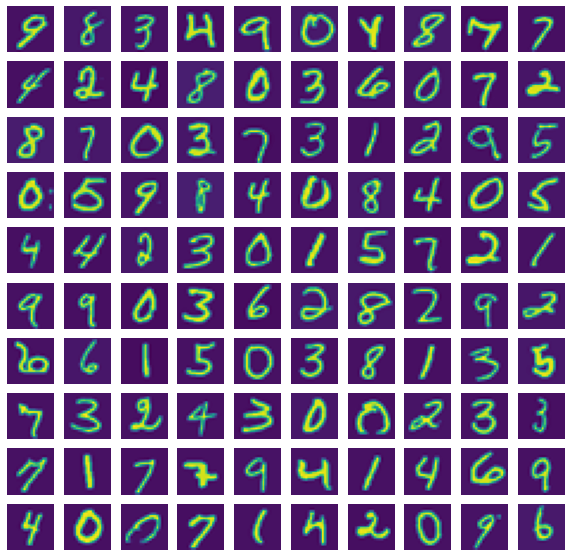

In [8]:
# Mostrar a grelha de dígitos
mostrarDigitos(sel)

Queremos desenvolver uma classificação Multi-Classe. Como iremos proceder? Neste caso o nosso target não é binário 1 vs. 0 mas uma abordagem Um vs. Todos - isto é, com base numas features queremos perceber qual das classes têm a maior probabilidade. Cada uma das observações terá assim alocada uma probabilidade de pertencer a cada um dos dígitos (0-9).
<br>
Tal como o prof. Andrew, vamos manter a classe 0 mapeada a 10.
<br>

# Exercício 2 - Regressão Logística Vectorizada

**Para descobrir esta probabilidade, vamos desenvolver 10 regressões logísticas paralelas - recorrendo ao poder de vectorizações para evitarmos muitos loops desnecessários - apenas vamos usar um loop para colocar uma optimização para cada dígito (target/output) a correr de cada vez.**

In [9]:
# Definir os parâmetros para um X_t e y_t fictício para a regressão logística vectorizada

theta_t = np.array([-2, -1, 1, 2])
X_t = np.hstack((np.ones(5).reshape(5,1),np.linspace(1,15,15).reshape(5,3, order='F')/10))
y_t = np.array([1,0,1,0,1])
lambda_t = 3

In [10]:
# Definir a função sigmóide 
def sigmoide(x: np.array)-> np.array:
    '''
    Retorna o valor sigmóide para cada element de um vector
    
    Args:
        x(np.array): Vector com os valores originais
    Returns:
        (np.array): Sigmóides resultantes do vector original
    '''
    return(1 / (1 + np.exp(-x)))

Vamos implementar uma versão regularizada da função de custo e do gradiente.
Isto é semelhante ao que fizémos em aulas anteriores:
   
<img src="assets/VectorizedLogisticRegression.JPG">
    

In [13]:
def lrFuncaoCusto(
    theta: np.array, 
    X: np.array, 
    y:np.array, 
    lambdas: int
) -> (np.array, np.array):
    '''
    Implementação da função de custo 
    e gradiente resultante da regressão logística 
    
    Args:
        theta(np.array): parâmetros theta
        X(np.array): vector de features - observações
        y(np.array): valores de output - classe
        lambdas(int): parâmetro de regularização
    
    '''
    m = len(y)
    n = X.shape[1]
    
    # Calculo da hipótese
    h = sigmoide(np.dot(X,theta))
    
    a = -y*np.log(h)
    b = (1-y)*np.log(1-h)
    
    regul = lambdas/(2*m)
    
    # Calcular a função de custo
    J = (sum(a-b))*(1/m) + regul * sum(theta[1:]**2)
               
    grad_regul = np.zeros(n)
    
    grad_regul[1:] = (lambdas/m)*theta[1:]
    
    # Calcular o gradiente
    grad = ((1/m)*(np.dot(X.T,(h-y))) + grad_regul)
    
    return J, grad

In [14]:
J, grad = lrFuncaoCusto(theta_t, X_t, y_t, lambda_t)

In [16]:
print('Função de custo para o exemplo arbitrário: {} '.format(J))
print('Gradiente para o exemplo arbitrário: {} '.format(grad))

Função de custo para o exemplo arbitrário: 2.534819396109744 
Gradiente para o exemplo arbitrário: [ 0.14656137 -0.54855841  0.72472227  1.39800296] 


# Exercício 3 - Treino Um vs. Todos (Multi Classe)

Agora, necessitamos de implementar uma optimização da nossa função de custo para cada um dos possíveis valores de target (dígitos distintos).
<br>
Ao desenvolver uma regressão logística para cada output, podemos capturar as features que melhor representação cada um dos dígitos. Estamos, basicamente, a desenvolver 10 regressões logísticas em paralelo (não são propriamente paralelizadas, já que recorremos a um loop para isso).

In [17]:
# Definir o parâmetro de regularização
lambdas = 0.1 

In [20]:
# Funcao Um vs. Todos

def umVsTodos(
    X: np.array, 
    y: np.array, 
    numero_classes: int, 
    lambdas: float
) -> np.array:
    '''
    Função para desenvolver uma regressão logística regularizada para
    cada classe até ao valor do número de classes.
   
    Argumentos:
        X(np.array): Vector das features - observações
        y(np.array): Vector com o outcome/target 
        num_classes(int): número de classes distintas
        lambdas(float): Parâmetro de regularização;
    
    Retorna:
        all_theta(np.array): Thetas para todas as regressões optimizadas
    '''
    
    m = X.shape[0]
    n = X.shape[1]
    
    # Adicionar o vector de uns
    ones_vector = np.ones((len(X),1))
    X_extended = np.hstack((ones_vector,X))
    
    # Criar os placeholders para cada um dos thetas para as diferentes regressões
    all_theta = np.zeros((numero_classes,n+1))
    
    # Opções para a optimização
    options= {'maxiter': 100}
    
    # Criar os thetas iniciais
    init_theta = np.zeros((m,1))
    
    # Iterar por cada classe e optimizar a função de custo para essa classe em particular 
    # Reescrevemos os placeholders que foram criados para cada theta 
    for label in np.arange(1,numero_classes):
        init_theta = np.zeros((n+1,1))
        target = np.array([1 if val == True else 0 for val in y==label])
        res = optimize.minimize(lrFuncaoCusto,
                        init_theta,
                        (X_extended, target, lambdas),
                        jac=True,
                        method='TNC',
                        options=options)
    
        all_theta[label-1,:] = res.x.T
    return all_theta

In [31]:
theta_final = umVsTodos(X, y, num_labels, lambdas)

In [32]:
def preverUmVsTodos(
    theta_final: np.array, 
    X: np.array
)-> np.array:
    '''
    Prever o outcome baseado no objecto theta_final
    Devolve um vector de probabilidades para cada observação 
    com a probabilidade do dígito ser 0 até 9  
    
    Argumentos:
        theta_final(np.array): theta para cada regressão logística treinada.
        X(np.array): Vector de observações e features.
    Retorna:
        np.array: Probabilidade de cada observação pertencer a cada classe.
    '''
    m = X.shape[0]

    # Adicionar o vector de uns
    vector_uns = np.ones((len(X),1))
    X_ext = np.hstack((vector_uns,X))
    
    return sigmoide(np.dot(X_ext, theta_final.T))

In [34]:
# Receber o vector com o valor previsto para cada classe vs nr. observações
previsoes = preverUmVsTodos(theta_final, X)

In [35]:
# Assignar a probabilidade máxima de cada observação onde 10 = 0
resultar = (np.argmax(previsoes, axis=1)+1).reshape(previsoes.shape[0],1)

In [38]:
print("A % de acerto do algoritmo é de {:.2%} ".format(sum(np.array([1 if val == True else 0 for val in resultar==y]))/len(y)))

A % de acerto do algoritmo é de 91.62% 


Conseguimos obter uma taxa de acerto de 91.62%. Por cada 10 dígitos, ~9.1 deles estavam correctamente classificados. E isto com um algoritmo linear! 
Mas.. muitas vezes as imagens não conseguem ser previstas de forma completamente linear, e outro tipo de problemas não conseguem ser resolvidos desta forma - temos de confiar em algoritmos mais sofisticados. 
<br>
<br>
Na próxima aula, vamos iniciar o estudo do conceito de Redes Neuronais - um algoritmo que é capaz de aprender padrões não lineares.